In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cbis-df:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4357659%2F7666891%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T015733Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db11e533ef22e38bef2de88349ec48acfa3ee0278df86dcecd3593864637f1ad3abf6c51e8d6d060e98d22c91ecfe64c3b72211786aa9a0fa9fb6f8e1aae09e9382a9f8dd21ed406879fb6da65ba7c34cc51dd6c0bac621adbff7e59727b61e73207c09405084f3fe3a2b72fccc5f0e460d851069a35911329cbfb6df42b350efde9b8469de19d5dcf6c04145e53461efc9992b786820e8cceb33222d11046ee61fe920a10b498cd988060d3a5e59aeec7a5d056454013d70a55f396c4d19254fb04fece3689e2e3e8078fbb76a9974ad0cb6860af792154eadacc1f9b93bd62197643bb576ccf9e25157850bd27bcf752cbfdcc1a93f71263fde1a40078fe3b9,cbis-ddsm-preprocess-aug:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4462481%2F7670141%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240222%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240222T015733Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3f3819f3fa43841adaacba6dc217d2b035bc34fd954dac7cc102505c12af4e938897439a0bcdc3e3d4e003ac47f704dc8ac1cacb3510cf4f43bae9d79f285f04b55e5ab1790c21089e8fd407e9a4bcac2fe52ace5cdf23ecd5c2521a7b1536103b0667f8eeb53ba6ceffbbdc0296ef316a6151967275c519d773591df78510ae63947fd8830fb1062b8d81e851cac17815c6a476e8597b20fa3fca86297610d505b87d359a48c73332007a62c2395c500a6212655b719a5ba51596284a4fc355e619ec185a9f3ad7d363c059a1be3decbbc108d8c8cf62b5f24006b6ca884724ac73b5be8c8c705ea49ec7ec03ecc0bcc6ca2e489d74d09e91fc0408ee6f6206'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 777286 bytes downloaded
Downloaded and uncompressed: cbis-df
[==================================================] 62617029 bytes downloaded
Downloaded and uncompressed: cbis-ddsm-preprocess-aug
Data source import complete.


In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import PIL
import re
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage import io, measure

!pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [3]:
data_dir = '/kaggle/input/cbis-ddsm-preprocess-aug/data'

## USE MASS ONLY

In [4]:
train_df = pd.read_csv(f'{data_dir}/train_df.csv')
val_df = pd.read_csv(f'{data_dir}/val_df.csv')
test_df = pd.read_csv(f'{data_dir}/test_df.csv')
train_df

,pathology,image_path
0,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...
1,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...
2,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...
3,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...
4,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...
...,...,...
5395,MALIGNANT,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/aug/...
5396,MALIGNANT,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/aug/...
5397,MALIGNANT,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/aug/...
5398,MALIGNANT,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/aug/...


In [5]:
def change_path_to_kaggle(df):
    df['kaggle_path'] = '0'
    for idx, row in df.iterrows():
        df.loc[idx, 'kaggle_path'] = row['image_path'].replace("E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data", data_dir)

change_path_to_kaggle(train_df)
change_path_to_kaggle(val_df)
change_path_to_kaggle(test_df)

train_df

,pathology,image_path,kaggle_path
0,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...,/kaggle/input/cbis-ddsm-preprocess-aug/data/pr...
1,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...,/kaggle/input/cbis-ddsm-preprocess-aug/data/pr...
2,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...,/kaggle/input/cbis-ddsm-preprocess-aug/data/pr...
3,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...,/kaggle/input/cbis-ddsm-preprocess-aug/data/pr...
4,BENIGN,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/prep...,/kaggle/input/cbis-ddsm-preprocess-aug/data/pr...
...,...,...,...
5395,MALIGNANT,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/aug/...,/kaggle/input/cbis-ddsm-preprocess-aug/data/au...
5396,MALIGNANT,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/aug/...,/kaggle/input/cbis-ddsm-preprocess-aug/data/au...
5397,MALIGNANT,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/aug/...,/kaggle/input/cbis-ddsm-preprocess-aug/data/au...
5398,MALIGNANT,E:/CBIS-DDSM/Breast_cancer_CBIS-DDSM/data/aug/...,/kaggle/input/cbis-ddsm-preprocess-aug/data/au...


In [6]:
img = cv2.imread(train_df['kaggle_path'][1])
print(img)

[[[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [254 254 254]
  [255 255 255]
  [254 254 254]]

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [232 232 232]
  [255 255 255]
  [255 255 255]]

 ...

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [253 253 253]
  [255 255 255]
  [254 254 254]]

 [[  2   2   2]
  [  2   2   2]
  [  2   2   2]
  ...
  [255 255 255]
  [253 253 253]
  [255 255 255]]]


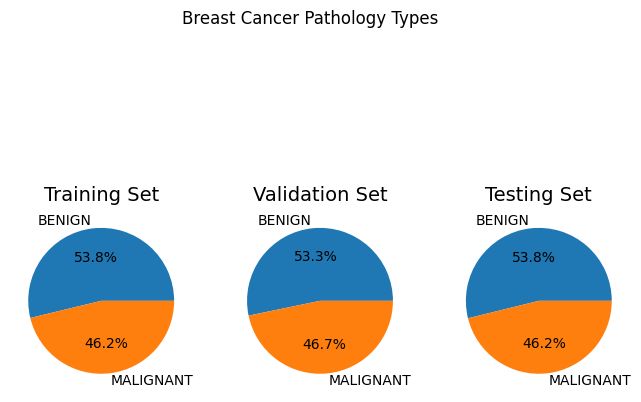

In [7]:
# pathology distributions
value = train_df['pathology'].value_counts()
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
fig.suptitle('Breast Cancer Pathology Types')
axs[0].pie(value, labels=value.index, autopct='%1.1f%%')
axs[0].set_title('Training Set', fontsize=14)

# pathology distributions
value_1 = val_df['pathology'].value_counts()
axs[1].pie(value_1, labels=value_1.index, autopct='%1.1f%%')
axs[1].set_title('Validation Set', fontsize=14)

value_2 = test_df['pathology'].value_counts()
axs[2].pie(value_2, labels=value_2.index, autopct='%1.1f%%')
axs[2].set_title('Testing Set', fontsize=14)

plt.show()

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='kaggle_path',
    y_col='pathology',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='kaggle_path',
    y_col='pathology',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='kaggle_path',
    y_col='pathology',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=True
)

Found 5400 validated image filenames belonging to 2 classes.
Found 169 validated image filenames belonging to 2 classes.
Found 169 validated image filenames belonging to 2 classes.


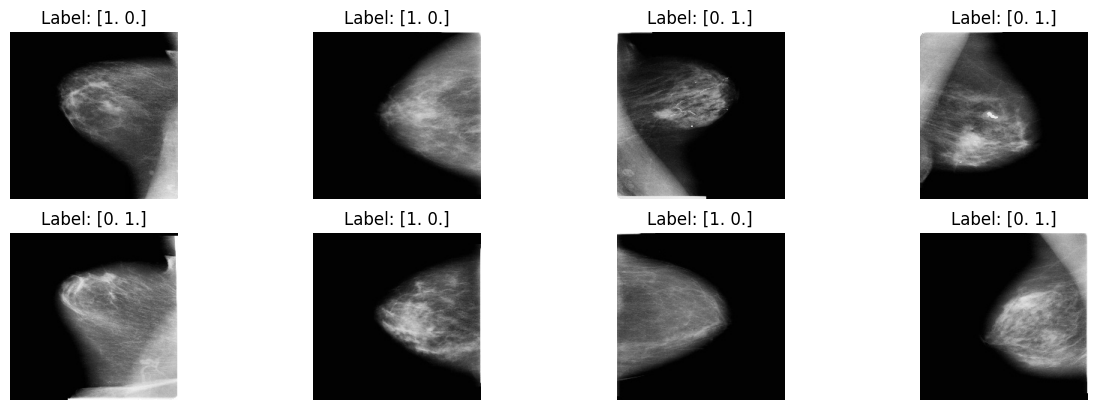

In [20]:
# Fetch a batch from the generator
sample_batch = train_generator[0]

# Extract the images and labels
combined_images, combined_labels = sample_batch

def reverse_preprocessing(image):
    return (image).astype(np.uint8)

# Visualize a few sample images
num_samples = min(16, combined_images.shape[0])

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(reverse_preprocessing(combined_images[i]))
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.show()

In [30]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.regularizers import l2

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
predictions = tf.keras.layers.Dense(2, activation='sigmoid')(x)

# Combine the base model and top layers
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=tf.keras.optimizers.experimental.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
def lr_scheduler(epoch):
    lr = 1e-4
    if epoch >= 10:
        lr *= 0.1
    return lr
lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [32]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50, callbacks=[lr_schedule, es])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50
675/675 [==============================] - 68s 77ms/step - loss: 1.2266 - accuracy: 0.5720 - val_loss: 1.1634 - val_accuracy: 0.5858 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/50
675/675 [==============================] - 47s 69ms/step - loss: 1.1292 - accuracy: 0.6185 - val_loss: 1.0895 - val_accuracy: 0.6272 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/50
675/675 [==============================] - 47s 69ms/step - loss: 1.0801 - accuracy: 0.6439 - val_loss: 1.0744 - val_accuracy: 0.6095 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/50
675/675 [==============================] - 48s 71ms/step - loss: 1.0614 - accuracy: 0.6519 - val_loss: 1.0587 - val_accuracy: 0.6154 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/50
675/675 [===========

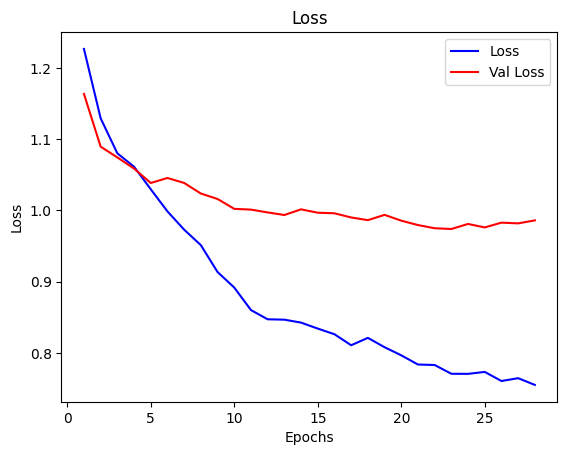

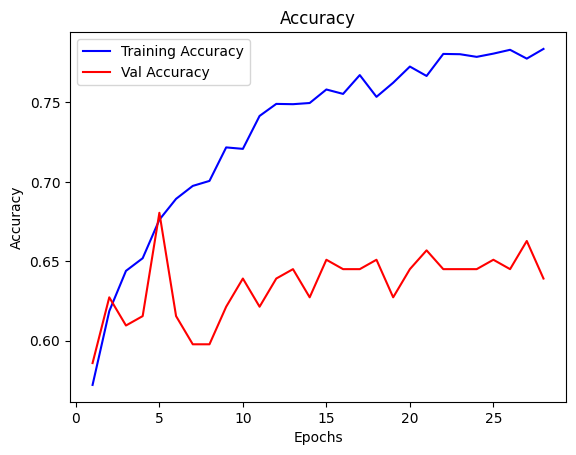

In [33]:
loss_values = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'b', label='Loss')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.title('Loss', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Val Accuracy')
plt.title('Accuracy', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
model.evaluate(test_generator)

169/169 [==============================] - 4s 22ms/step - loss: 0.9041 - accuracy: 0.6864


[0.9040656685829163, 0.6863905191421509]

169/169 [==============================] - 35s 21ms/step
AUC: 0.6007


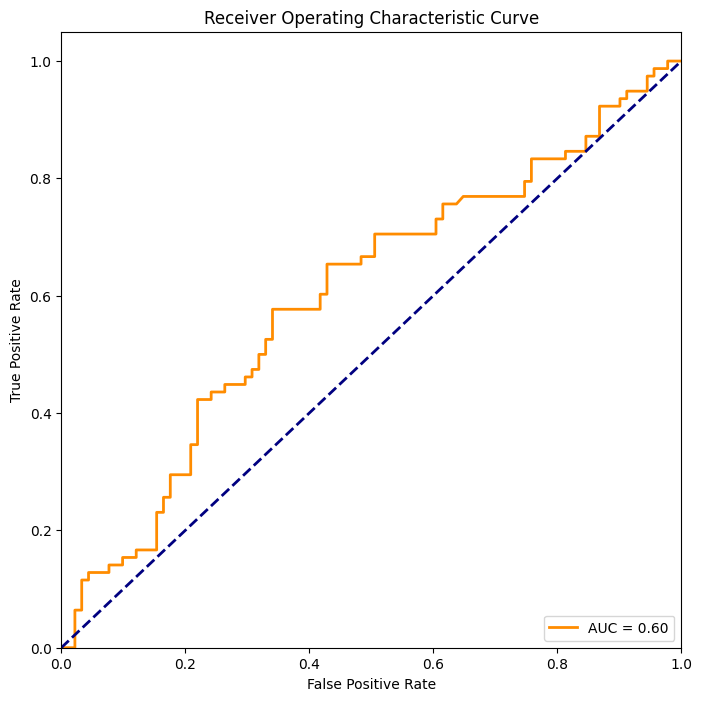

In [35]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

predictions = model.predict(test_generator)
true_labels = test_generator.classes
fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1])

roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.60      0.57      0.59        91
           1       0.53      0.56      0.55        78

    accuracy                           0.57       169
   macro avg       0.57      0.57      0.57       169
weighted avg       0.57      0.57      0.57       169



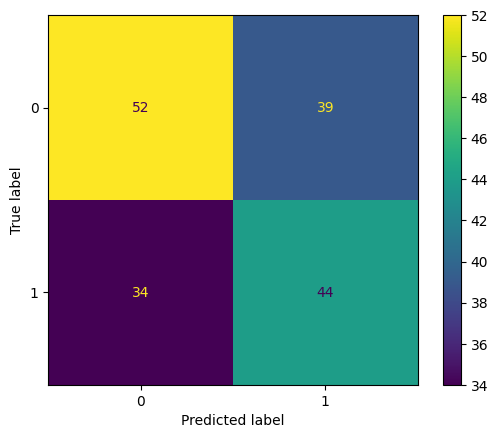

In [36]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

true_labels = test_generator.classes
# Convert predicted probabilities to predicted labels (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

print(classification_report(true_labels,predicted_labels))
ConfusionMatrixDisplay.from_predictions(true_labels,predicted_labels)

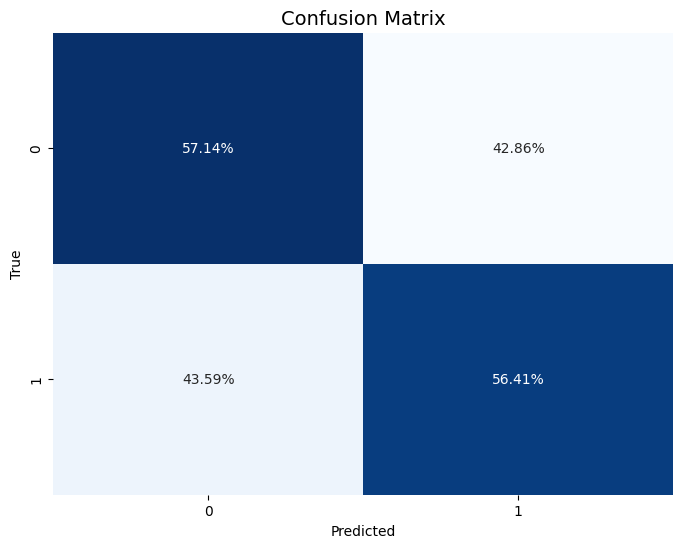

              precision    recall  f1-score   support

      BENIGN       0.60      0.57      0.59        91
   MALIGNANT       0.53      0.56      0.55        78

    accuracy                           0.57       169
   macro avg       0.57      0.57      0.57       169
weighted avg       0.57      0.57      0.57       169



In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# create function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    """plots a normalized confusion matrix as a heatmap."""
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)
    # Normalize confusion matrix
    normalized_cm = cm / row_sums

    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# Confusion matrix as percentage
cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm=cm, title='Confusion Matrix')

# Classification report
print(classification_report(true_labels, predicted_labels, target_names=list(test_generator.class_indices.keys())))

In [ ]:
model.save('/kaggle/working/your_model.h5')